In [43]:
%matplotlib notebook
# starter code
import random
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import networkx as nx
from graph_tool.all import load_graph, shortest_distance, GraphView
from networkx.drawing.nx_agraph import graphviz_layout

from cascade import gen_nontrivial_cascade
from utils import get_rank_index

seed = 123456
random.seed(seed)
np.random.seed(seed)

gtype = 'grid'
g = load_graph('data/{}/2-6/graph.gt'.format(gtype))
gnx = nx.read_graphml('data/{}/2-6/graph.graphml'.format(gtype))
gnx = nx.relabel_nodes(gnx, {i: int(i) for i in gnx.nodes_iter()})
N1, N2 = 100, 100
p, q = 0.5, 0.3

pos = graphviz_layout(gnx, root=0)

infection_times, source, obs_nodes, tree = gen_nontrivial_cascade(g, p, q, model='ic', return_tree=True)

In [69]:
from graph_tool import Graph
from steiner_tree_mst import init_visitor, extract_edges_from_pred
from graph_tool.search import pbfs_search
from utils import earliest_obs_node

root = earliest_obs_node(obs_nodes, infection_times)

def nikolaj_bfs(g, root, infection_times, source, terminals,
                debug=False,
                verbose=True):
    terminals = set(terminals)
    visited = {root}
    edges = []

    terminals_sorted = list(sorted(terminals,
                                   key=lambda t: (infection_times[t], (t not in visited))))
    while len(terminals_sorted) > 0:        
        n = terminals_sorted.pop(0)
#         print('n', n)
#         print('vistied', visited)
        queue = [n] 
        while len(queue) > 0:            
            u = queue.pop(0)
            for v in g.vertex(u).all_neighbours():
                v = int(v)
                if v not in visited:
                    edges.append((u, v))
                    visited.add(v)
                    if v not in terminals:
                        # continue with non-terminal node
                        queue.append(v)
        # needs to sort the terminals because `visited` changed
        terminals_sorted = list(
            sorted(terminals_sorted,
                   key=lambda t: (infection_times[t], (t not in visited))))

    assert len(visited.intersection(terminals)) == len(terminals)
    
    # build the tree
    t = Graph(directed=True)

    for _ in range(g.num_vertices()):
        t.add_vertex()

    for (u, v) in edges:
        t.add_edge(u, v)

    if True:
        # mask out redundant edges
        vis = init_visitor(t, root)
        pbfs_search(t, source=root, terminals=list(terminals), visitor=vis)

        minimum_edges = {e
                         for u in terminals
                         for e in extract_edges_from_pred(t, root, u, vis.pred)}
        # print(minimum_edges)
        efilt = t.new_edge_property('bool')
        efilt.a = False
        for u, v in minimum_edges:
            efilt[u, v] = True
        t.set_edge_filter(efilt)

        vfilt = t.new_vertex_property('bool')
        vfilt.a = False
        tree_nodes = {u for e in minimum_edges for u in e}
        for v in tree_nodes:
            vfilt[v] = True
        t.set_vertex_filter(vfilt)    
    
    return t

In [73]:
def is_order_respected(tree, root, obs_nodes, infection_times):
    tree = GraphView(tree)
    obs_set = set(obs_nodes)
    vfilt = tree.new_vertex_property('bool')
    vfilt.a = True
    tree.set_vertex_filter(vfilt)

    leaves = [o for o in obs_nodes if tree.vertex(o).out_degree() == 0]
    vis = init_visitor(tree, root)
    pbfs_search(tree, root, terminals=leaves, visitor=vis, count_threshold=-1)
#     print(leaves)
    for l in leaves:
        edges = extract_edges_from_pred(tree, root, l, vis.pred)
        edges = edges[::-1]
#         print('root', root)
#         print('l', l)
#         print('edges', edges)
        path = list(edges[0]) + [u for _, u in edges[1:]]
        useful_nodes_on_path = [v for v in path if v in obs_set]

        for i in range(len(useful_nodes_on_path)-1):
            u, v = useful_nodes_on_path[i: i+2]
            if infection_times[u] > infection_times[v]:
                return False
    return True

In [75]:
from tqdm import tqdm
from feasibility import is_feasible

for i in tqdm(range(100)):
    infection_times, source, obs_nodes, true_tree = gen_nontrivial_cascade(g, p, q, model='si', return_tree=True)
    root = earliest_obs_node(obs_nodes, infection_times)

    tree = nikolaj_bfs(
        g, root, infection_times, source, obs_nodes,
        debug=False,
        verbose=False
    )
    assert is_order_respected(tree, root, obs_nodes, infection_times)
    assert is_feasible(tree, root, obs_nodes, infection_times)

100%|██████████| 100/100 [00:06<00:00, 14.74it/s]


In [59]:
root

49

<IPython.core.display.Javascript object>


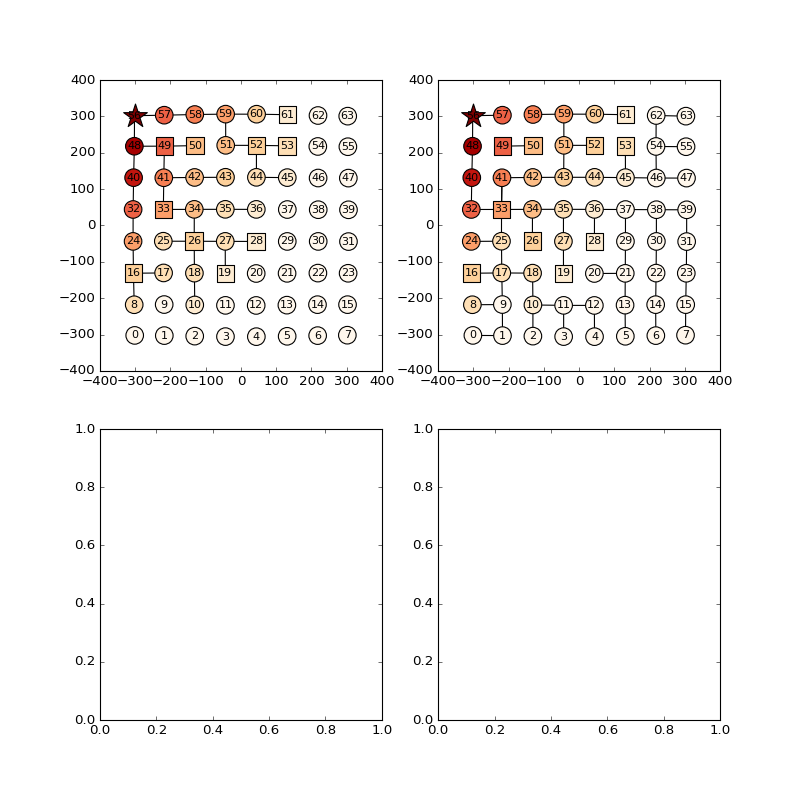

In [58]:
from plot_utils import plot_snapshot
from utils import extract_edges
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 0],
              edges=extract_edges(true_tree))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
             ax=ax[0, 1], arrows=True,
             edges=extract_edges(tree))